# Exoplanet Hunting

## Abstract

The peculiarity of this problem is that it has highly imbalanced training and test datasets. To deal with the problem, the SMOTE (oversampling) technique combined with random undersampling is used as per ([Chawla et al., 2002](https://arxiv.org/pdf/1106.1813.pdf)). As for the model, the following CNN architecture is used to achieve **perfect score (100%)**:

* **Input layer**;
* **1D convolutional layer**, consisting of 10 2x2 filters, L2 regularization and RELU activation function;
* **1D max pooling layer**, window size - 2x2, stride - 2;
* **Dropout** with 20% probability;
* **Fully connected layer** with 32 neurons and RELU activation function;
* **Dropout** with 40% probability;
* **Fully connected layer** with 18 neurons and RELU activation function;
* **Output layer** with sigmoid function.

As it is suggested in papers ([Hinton et al., 2021](https://arxiv.org/pdf/1207.0580.pdf), [Park & Kwak, 2016](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf)), we use 20% dropout after 1D CONV layers and 40-50% dropout after fully connected layers. In our model, we use **Adam** optimizer, **binary-crossentropy** loss function, **batch size of 64** and **30 epochs**. Also, we use **exponential decay** and **early stopping** to prevent non-convergence and overfitting.

Training on GPU involves a certain degree of randomness. On average, this model achieves a perfect score on $y=1$ (star has an exoplanet) around 20 times for every 200 simulations.

___

## Main

### Library Import

* **numpy** and **pandas** are for data handling
* **matplotlib** and **seaborn** are for plotting
* **sklearn**, **imblearn** and **itertools** are for data processing and metric evaluation
* **keras** and **tensorflow** are for fitting and predicting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.optimizers import Adam as KerasAdam
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from itertools import chain

pd.options.mode.chained_assignment = None  # default='warn'


### Data Study

#### General

Below you may see the head of the data and how unbalanced the data are, and also plots of FLUX values of stars with exoplanets and without them. These plots describe stars in terms of their characteristics (w/ or without exoplanets), provide insight on data and illustrative information on outliers. Specifically, we may differentiate whether a star has exoplanets or not - the systems with exoplanets are sinusoid-looking whereas stars without exoplanets are more stable and condensed

In [3]:
exoTrain = pd.read_csv('exoTrain.csv')
exoTest = pd.read_csv('exoTest.csv')

exoTrain.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'exoTrain.csv'

In [ ]:
print(exoTrain['LABEL'].value_counts())
print(exoTest['LABEL'].value_counts())

LABEL
1    5050
2      37
Name: count, dtype: int64
LABEL
1    565
2      5
Name: count, dtype: int64


In [ ]:
def flux_graph(dataset, row, dataframe, planet):
    if dataframe:
        fig = plt.figure(figsize=(20,5), facecolor=(.18, .31, .31))
        ax = fig.add_subplot()
        ax.set_facecolor('#004d4d')
        ax.set_title(planet, color='white', fontsize=22)
        ax.set_xlabel('time', color='white', fontsize=18)
        ax.set_ylabel('flux_' + str(row), color='white', fontsize=18)
        ax.grid(False)
        flux_time = list(dataset.columns)
        flux_values = dataset[flux_time].iloc[row]
        ax.plot([i + 1 for i in range(dataset.shape[1])], flux_values, '#00ffff')
        ax.tick_params(colors = 'black', labelcolor='#00ffff', labelsize=14)
        plt.show()
    else:
        fig = plt.figure(figsize=(20,5), facecolor=(.18, .31, .31))
        ax = fig.add_subplot()
        ax.set_facecolor('#004d4d')
        ax.set_title(planet, color='white', fontsize=22)
        ax.set_xlabel('time', color='white', fontsize=18)
        ax.set_ylabel('flux_' + str(row), color='white', fontsize=18)
        ax.grid(False)
        flux_values = dataset[row]
        ax.plot([i + 1 for i in range(dataset.shape[1])], flux_values, '#00ffff')
        ax.tick_params(colors = 'black', labelcolor='#00ffff', labelsize=14)
        plt.show()

In [ ]:
def show_graph(dataframe, dataset):
    with_planet = exoTrain[exoTrain['LABEL'] == 2].head(3).index
    wo_planet = exoTrain[exoTrain['LABEL'] == 1].head(3).index

    for row in with_planet:
        flux_graph(dataset, row, dataframe, planet = 'with_planet')
    for row in wo_planet:
        flux_graph(dataset, row, dataframe, planet = 'wo_planet')

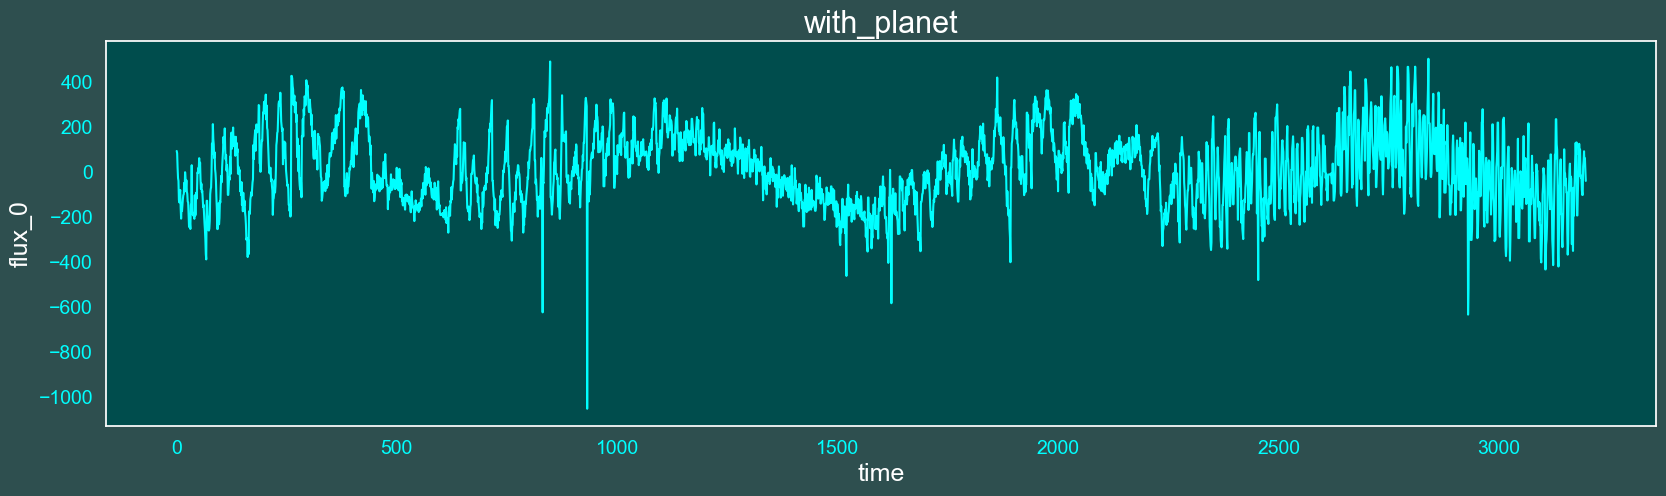

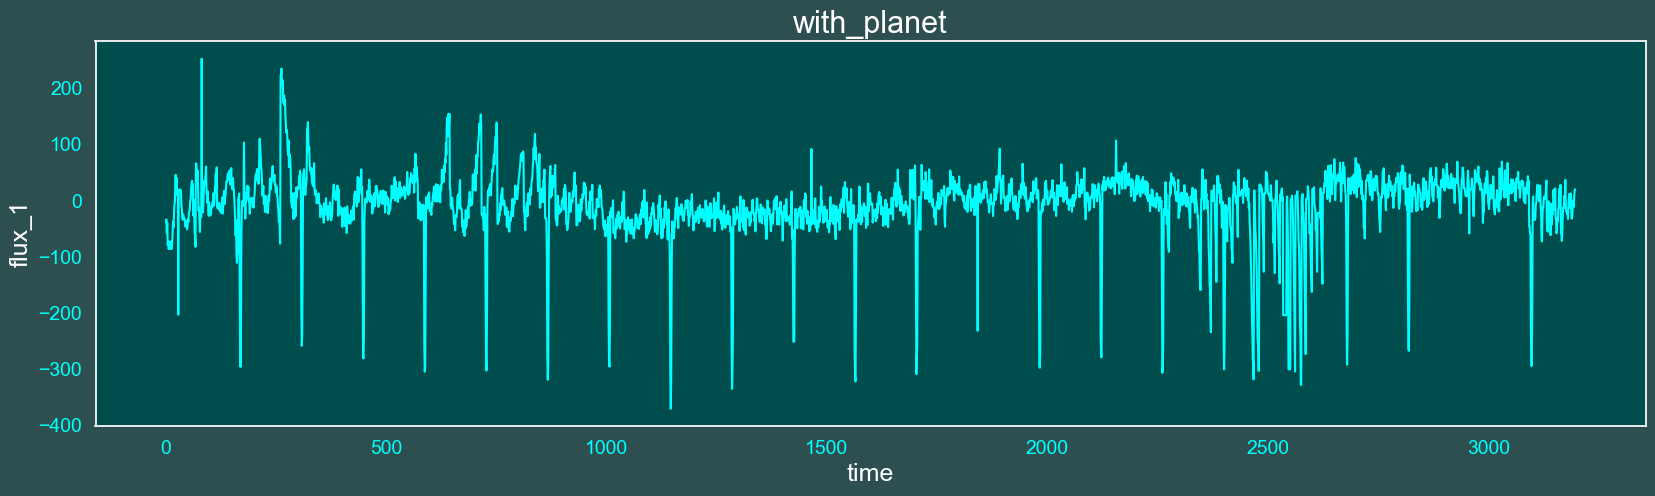

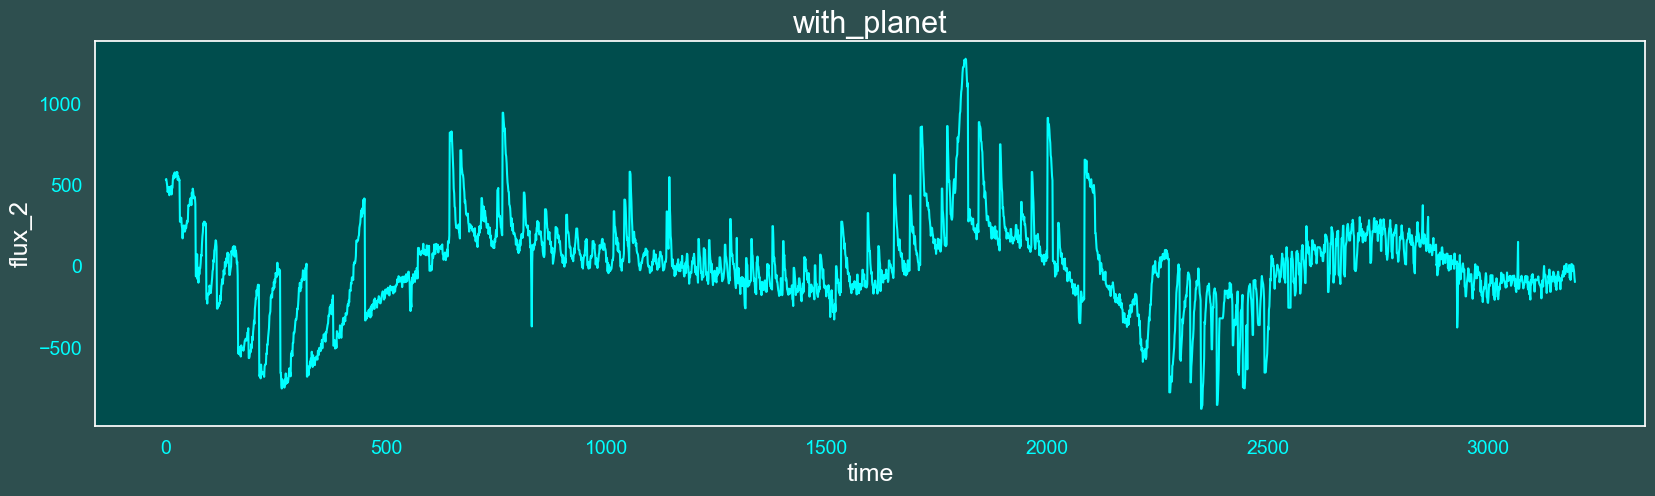

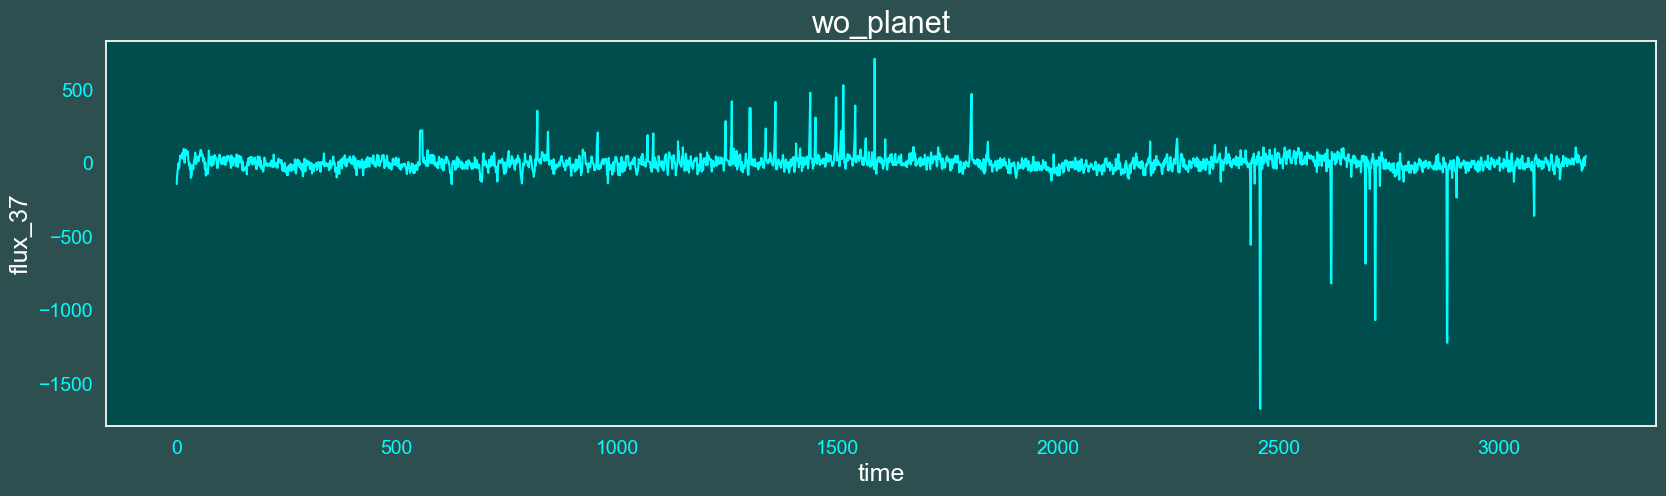

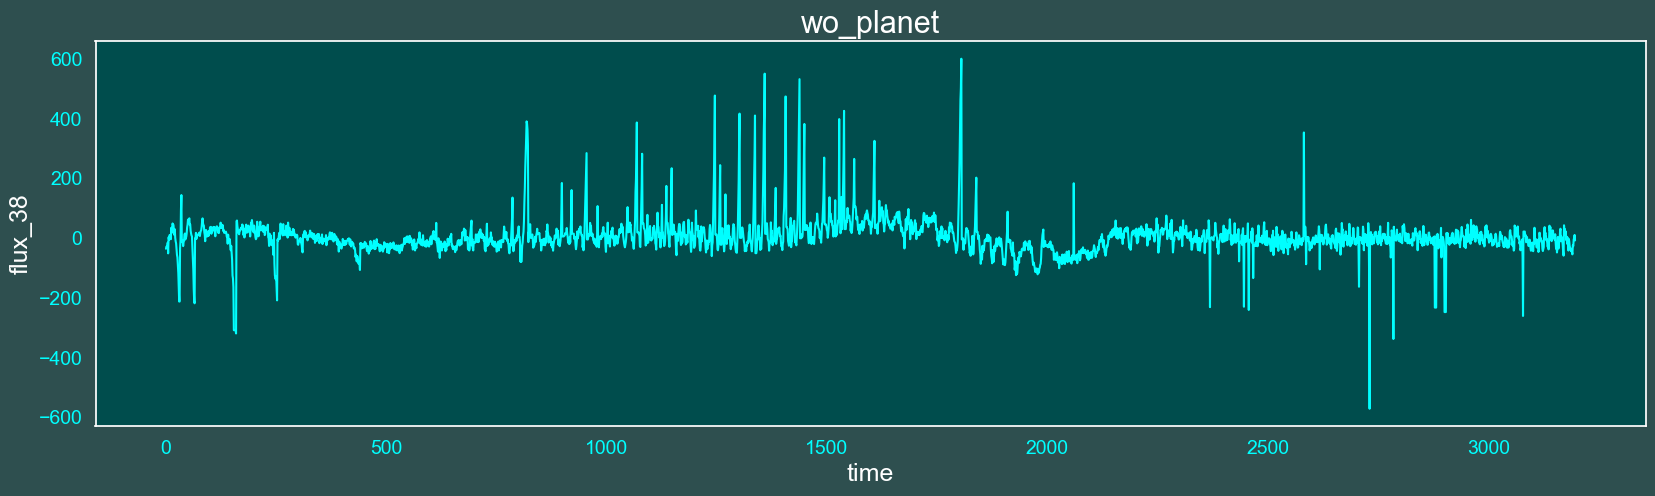

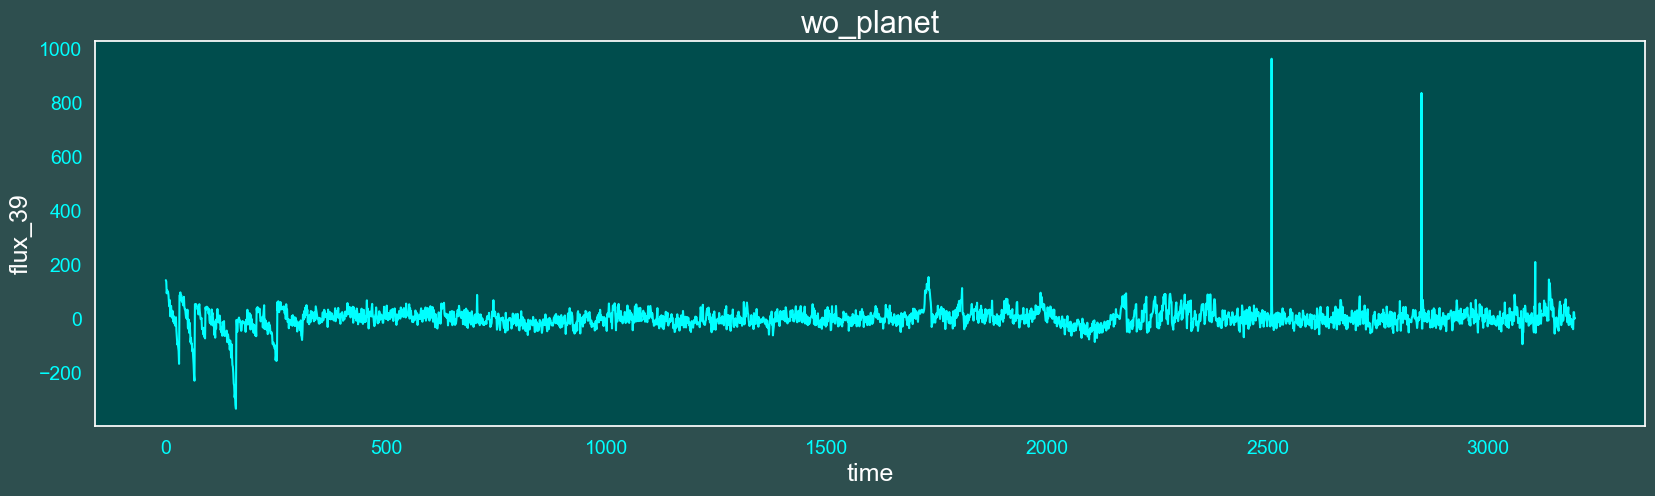

In [ ]:
show_graph(True, dataset = exoTrain.loc[:, exoTrain.columns != 'LABEL'])

#### Scaling

The study on data and its FLUX values led us to conclude that the scaled data were less efficient than the raw data. Here, scaling affects slight differences observed on plots between FLUX values of stars with exoplanets and without them. We have trained the model on both scaled and unscaled data - the metrics were generally higher with the unscaled version. For educational purposes, we plot the same graphs using the data after scaling. As you can see below, scaling the data leads to degradation of distinction between stars with and without exoplanets

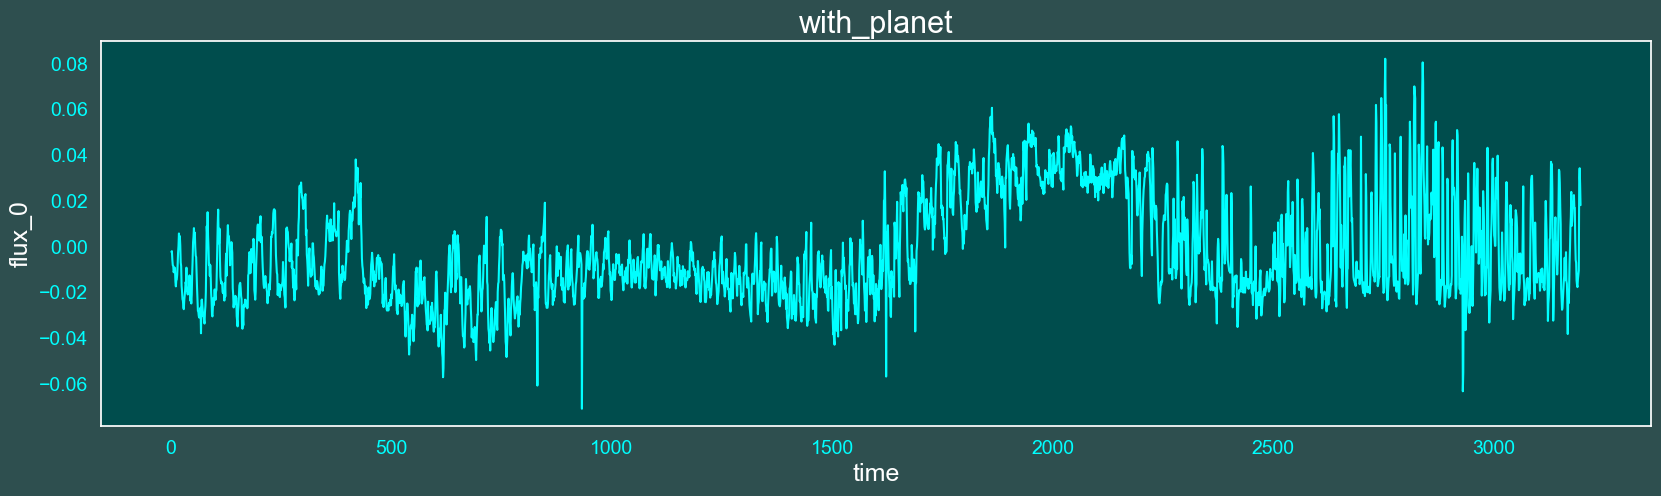

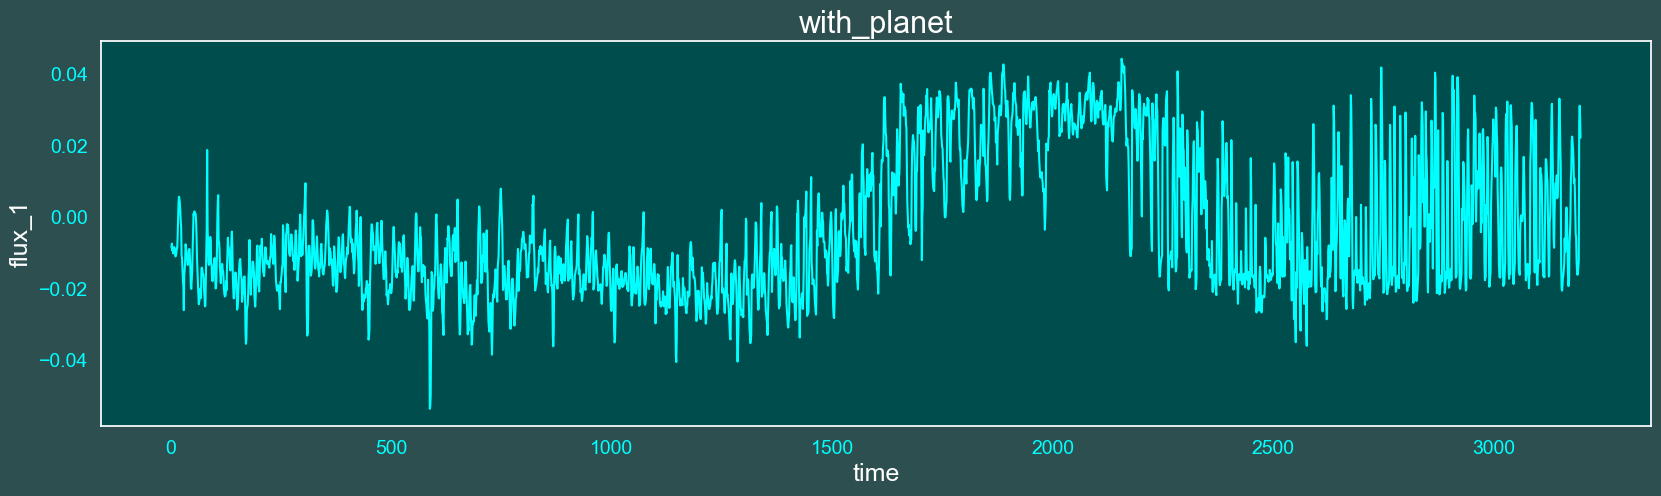

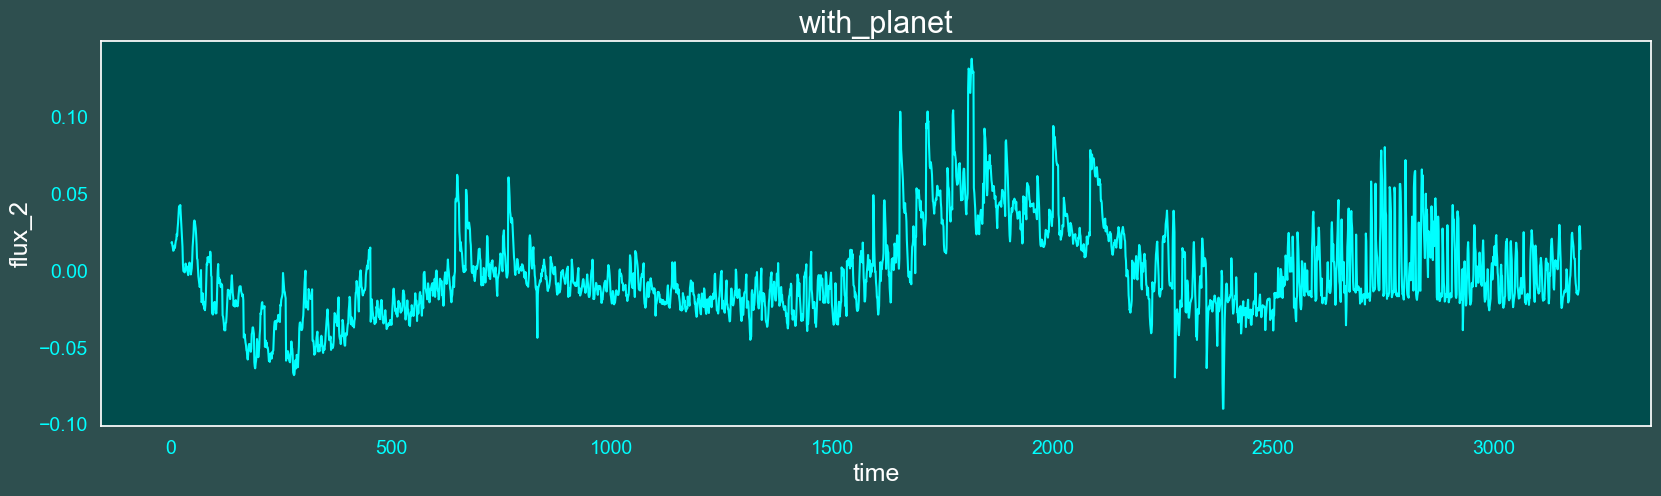

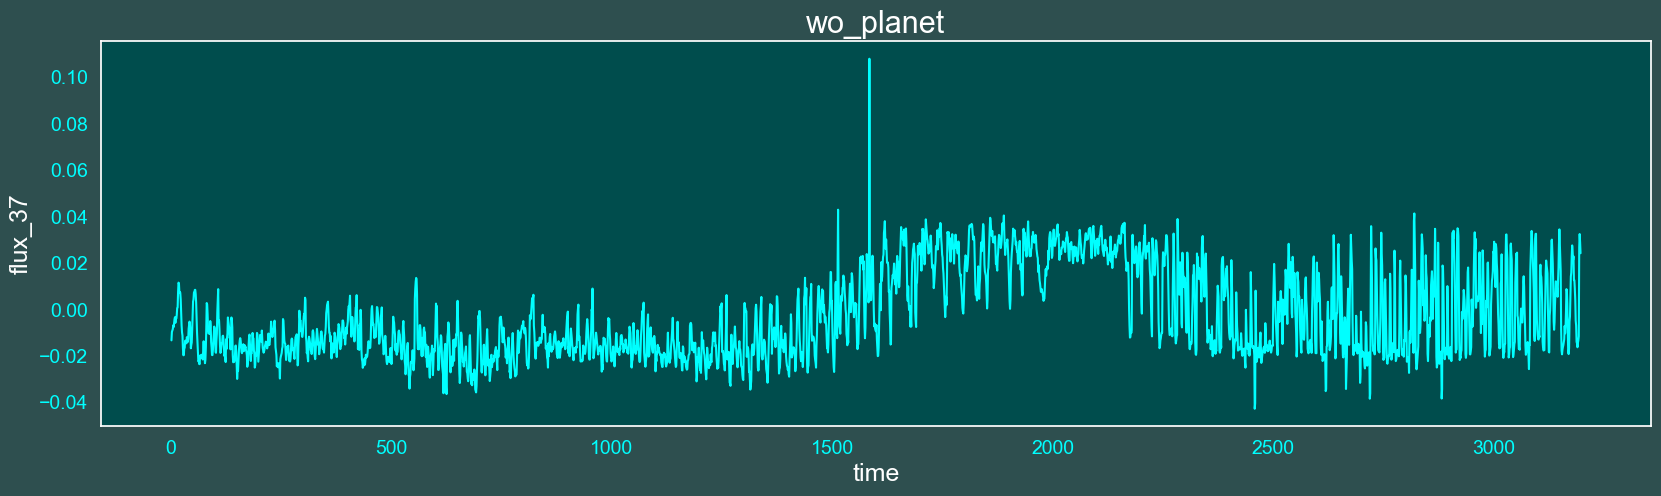

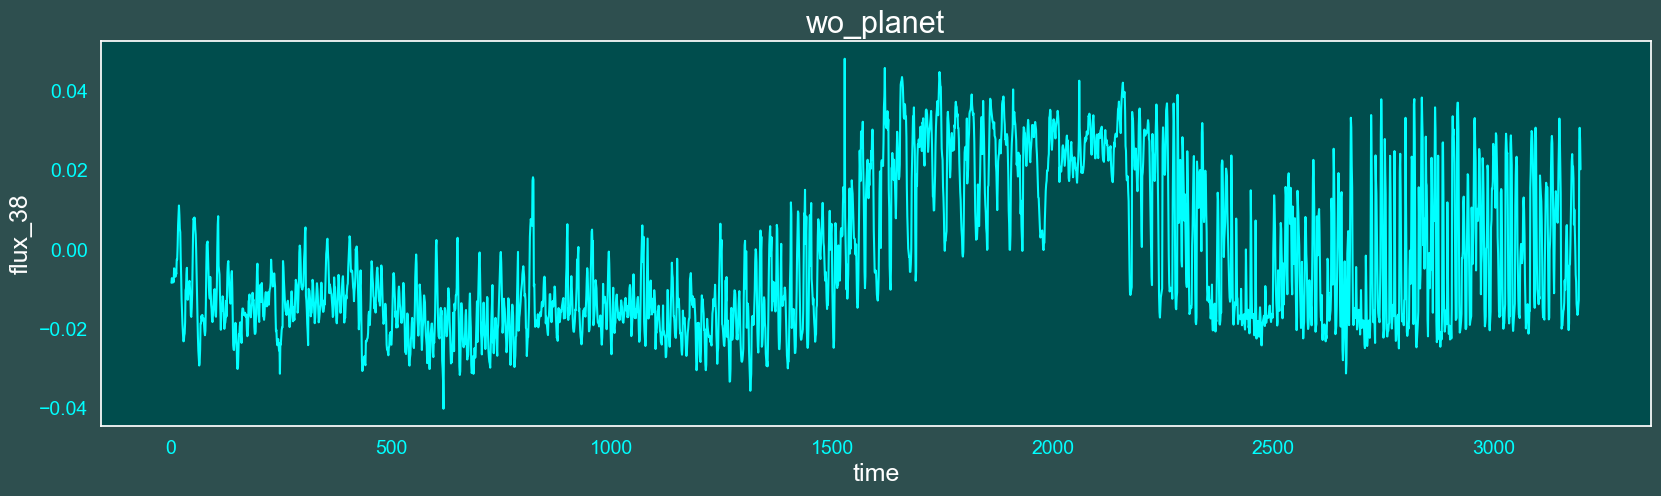

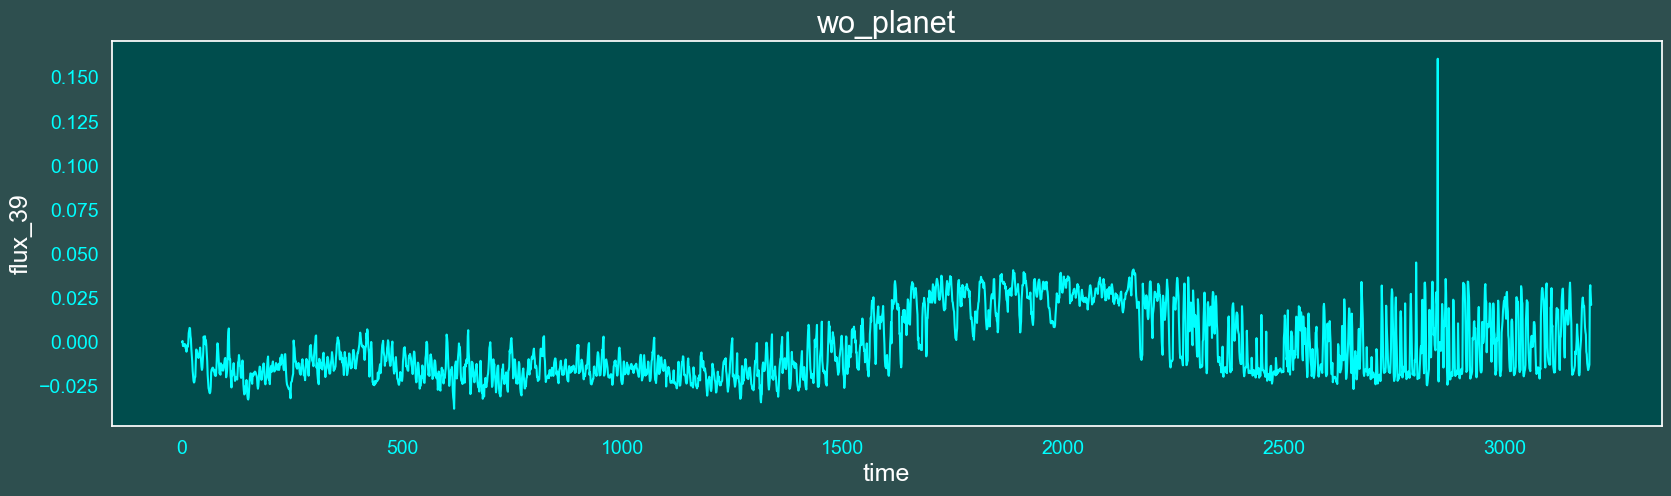

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(exoTrain.loc[:, exoTrain.columns != 'LABEL'])
show_graph(False, scaled_data)

#### Outliers

The data is very rich in outliers so this fact must be treated appropriately. Since we have not applied scaling it is a delicate task to come up with a treshold for truncation. After numerous tests a good approach is to substitute the maximum FLUX value of each star with its mean. Below you may see a plot comparsion of data before and after outlier handling

In [ ]:
def handle_outliers(dataset, num_iterations):
    """Replace per-row max and min with the row mean for a number of iterations.
    Avoids chained assignment warnings by operating on numpy array and reassigning.
    Parameters
    ----------
    dataset: pd.DataFrame
        Original flux dataframe (copy will be made)
    num_iterations: int
        How many times to repeat replacement (diminishing effect after 2).
    """
    # Work on a copy to be explicit and safe
    data = dataset.to_numpy(copy=True)
    for _ in range(num_iterations):
        row_means = data.mean(axis=1)
        # Argmax / argmin positions per row
        max_pos = data.argmax(axis=1)
        min_pos = data.argmin(axis=1)
        # Replace using advanced indexing
        rows = np.arange(data.shape[0])
        data[rows, max_pos] = row_means
        data[rows, min_pos] = row_means
    # Return a DataFrame with original columns and index preserved
    return pd.DataFrame(data, columns=dataset.columns, index=dataset.index)

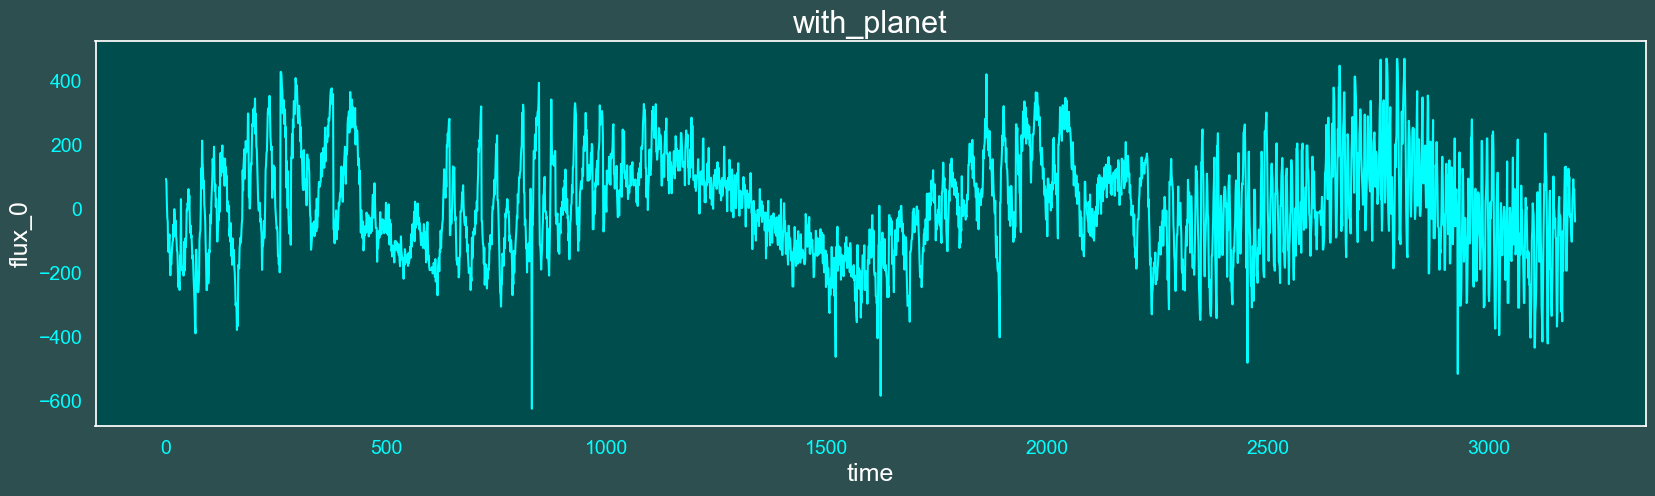

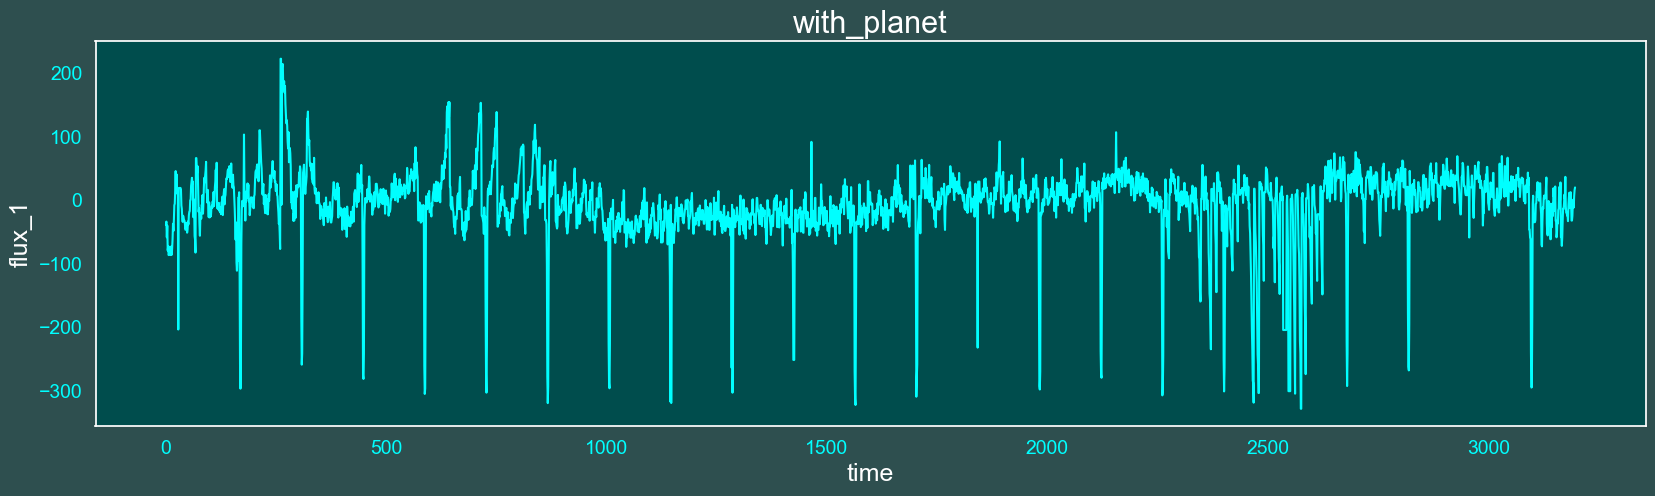

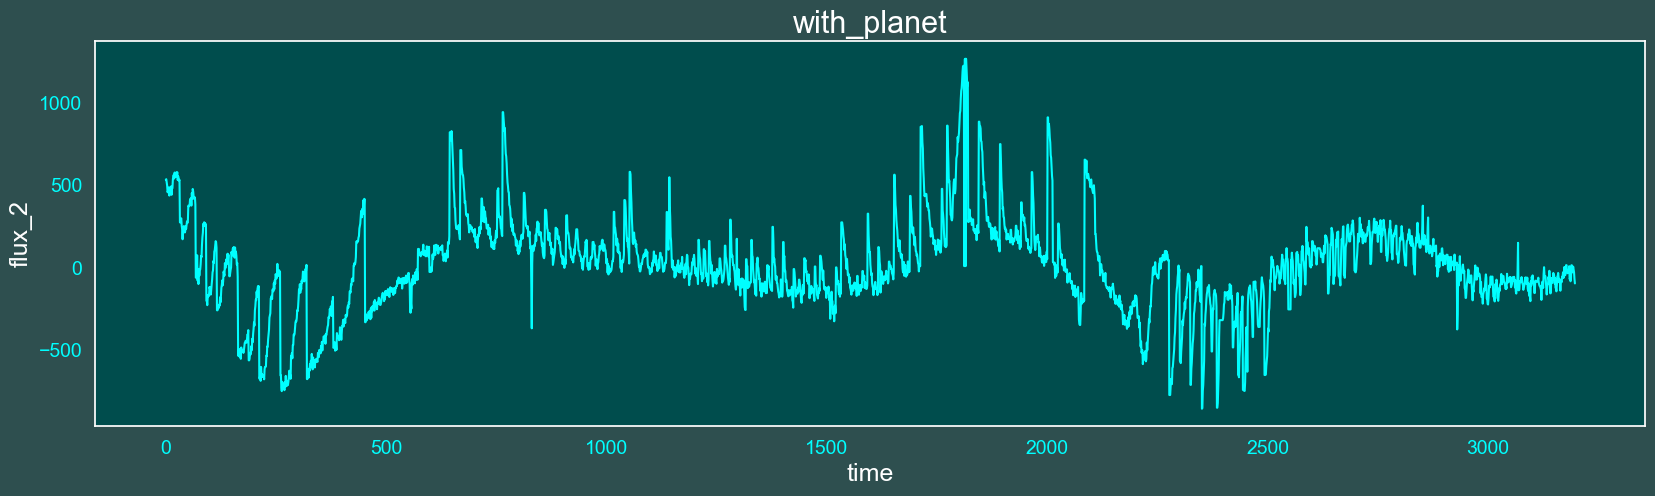

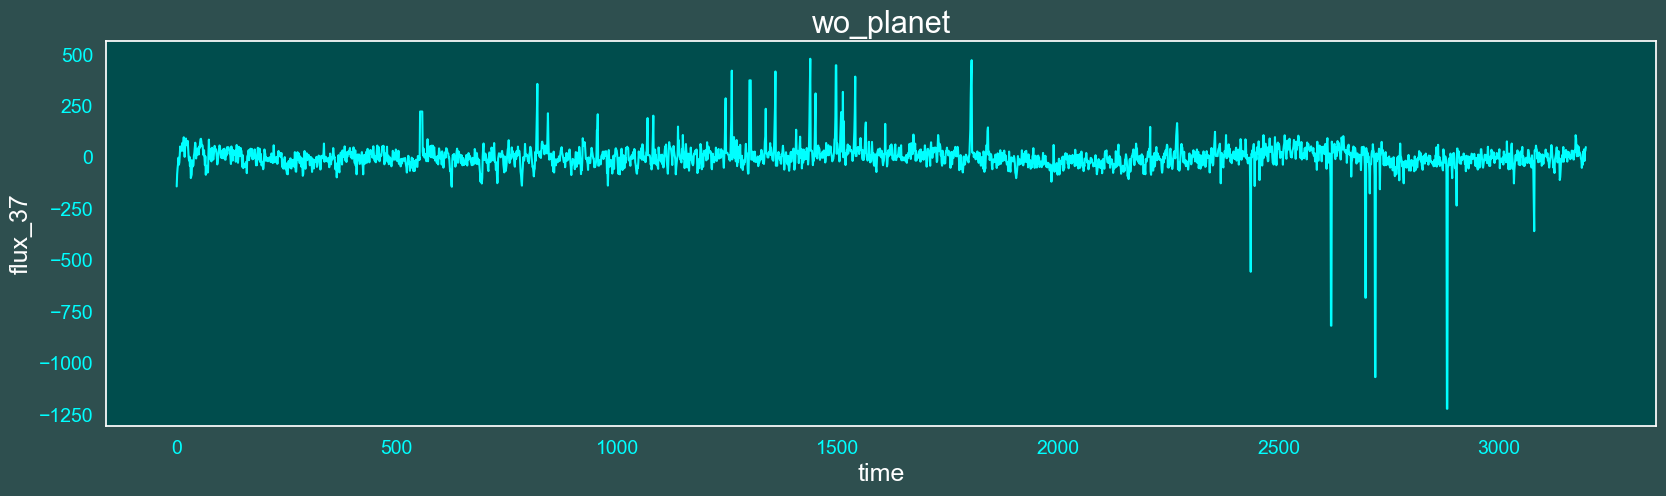

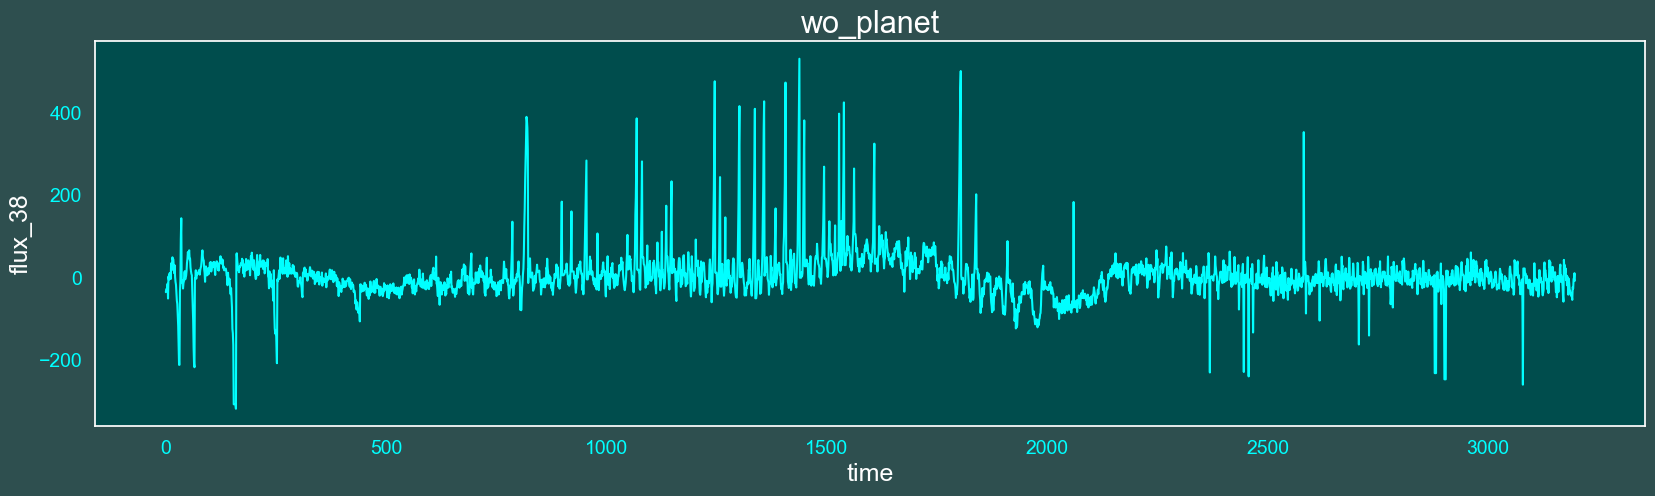

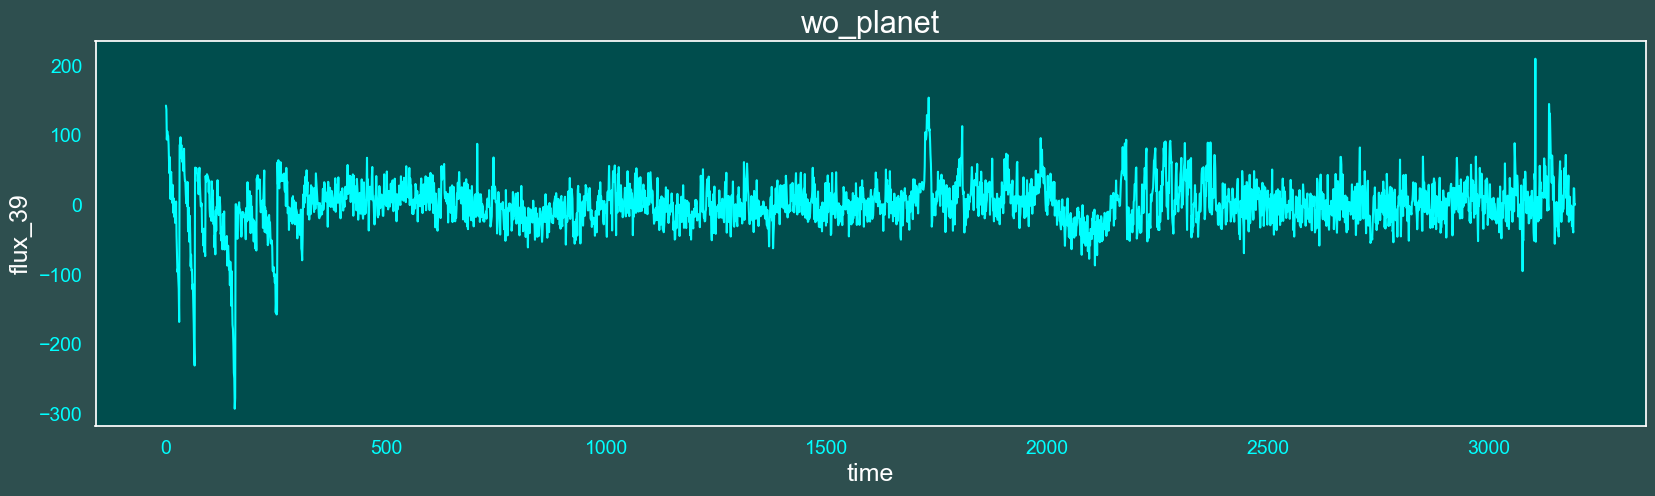

In [ ]:
handled_dataset = handle_outliers(exoTrain.loc[:, exoTrain.columns != 'LABEL'], 2)
show_graph(True, handled_dataset)

#### SMOTE

We begin by relabling the classes to a 0-1 (0 - with exoplanet(s), 1- without exoplanet(s)) convention and defining the function for SMOTE. We oversample only the minor part of data ($y=1$) and undersample the major part of the data ($y=0$). In numbers, ~2k observations of $y=0$ were removed and ~1k observations of $y=1$ were added

In [ ]:
def lable_change(y_train, y_test):
    labler = lambda x: 1 if x == 2 else 0
    y_train_01, y_test_01 = y_train.apply(labler), y_test.apply(labler)

    return y_train_01, y_test_01

In [ ]:
def smote(x_train, y_train):
    #smote = SMOTE(random_state=17, sampling_strategy='minority')
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.3)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    x_train_res, y_train_res = pipeline.fit_resample(x_train, y_train)

    return x_train_res, y_train_res

In [ ]:
y_smote_test = exoTrain.loc[:, 'LABEL']
print(y_smote_test.value_counts())
_, y_smote_test = smote(handled_dataset, y_smote_test)
print(y_smote_test.value_counts())

LABEL
1    5050
2      37
Name: count, dtype: int64
LABEL
1    3366
2    1010
Name: count, dtype: int64
LABEL
1    3366
2    1010
Name: count, dtype: int64


### Datasets and Metrics

Finally, let's define our datasets, confusion matrix and metrics functions, and create our model.

In [ ]:
# Define training and testing datasets
def datasets():
    x_train, y_train = exoTrain.loc[:, exoTrain.columns != 'LABEL'], exoTrain.loc[:, 'LABEL']
    x_test, y_test = exoTest.loc[:, exoTest.columns != 'LABEL'], exoTest.loc[:, 'LABEL']
    
    #fill NaNs with mean (no NaNs)
    #for column in x_train:
        #x_train[column] = x_train[column].fillna(round(x_train[column].mean(), 2))

    #x_train, x_test = scale(x_train, x_test)
    x_train = handle_outliers(x_train, 2)
    x_train, y_train = smote(x_train, y_train)
    y_train, y_test = lable_change(y_train, y_test)

    n_features = x_train.shape[1]

    return x_train, y_train, x_test, y_test, n_features

In [ ]:
# Graph train and test accuracy
def graph_acc(history):
    # Plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    # Plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [ ]:
# Confusion matrix
def conf_matrix(y_test, y_pred):

    matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(matrix, columns=[0, 1], index = [0, 1])
    df_cm.index.name = 'Truth'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, cmap="BuGn", annot=True, annot_kws={"size": 16})
    plt.show()
    
    return matrix

In [ ]:
# Print prediction metrics
def prediction_metrics(y_test, y_pred, y_class_pred, matrix):
    FP = matrix[0][1] 
    FN = matrix[1][0]
    TP = matrix[1][1]
    TN = matrix[0][0]

    sens = TP/(TP+FN)
    spec = TN/(TN+FP) 
    g_mean = np.sqrt(sens * spec)

    accuracy = accuracy_score(y_test, y_class_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_class_pred)
    precision = precision_score(y_test, y_class_pred)
    recall = recall_score(y_test, y_class_pred)
    f1 = f1_score(y_test, y_class_pred)
    auc = roc_auc_score(y_test, y_pred)

    print('\t\t Prediction Metrics\n')
    print("Accuracy:\t", "{:0.3f}".format(accuracy))
    print("Precision:\t", "{:0.3f}".format(precision))
    print("Recall:\t\t", "{:0.3f}".format(recall))
    print("\nF1 Score:\t", "{:0.3f}".format(f1))
    print("ROC AUC:\t", "{:0.3f}".format(auc))
    print("Balanced\nAccuracy:\t", "{:0.3f}".format(balanced_accuracy))
    print("\nSensitivity:\t", "{:0.3f}".format(sens))
    print("Specificity:\t", "{:0.3f}".format(spec))
    print("Geometric Mean:\t", "{:0.3f}".format(g_mean))

### Model Structure

* **Input layer**;
* **1D convolutional layer**, consisting of 10 2x2 filters, L2 regularization and RELU activation function;
* **1D max pooling layer**, window size - 2x2, stride - 2;
* **Dropout** with 20% probability;
* **Fully connected layer** with 48 neurons and RELU activation function;
* **Dropout** with 40% probability;
* **Fully connected layer** with 18 neurons and RELU activation function;
* **Output layer** with sigmoid function.

In our model, we use **Adam** optimizer, **binary-crossentropy** loss function, **batch size of 64** and **30 epochs**. Also, we use **exponential decay** and **early stopping**.

### Function Capsule and Results

In [ ]:
def cnn_model():

    # Data preparation
    x_train, y_train, x_test, y_test, n_features = datasets()
    x_train, y_train = shuffle(x_train, y_train) # shuffle the data to avoid stagnant 0.0000e+00 val_accuracy

    # Architecture
    model = Sequential([
        Input(shape=(3197,), name='flux_input'),
        Reshape((3197, 1)),
        Conv1D(filters=10, kernel_size=2, activation='relu', kernel_regularizer='l2'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        Dense(48, activation="relu"),
        Dropout(0.4),
        Dense(18, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    # Representation of architecture
    print(model.summary())

    # Compile model
    lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.94)

    model.compile(optimizer = Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

    # Fit model
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(x_train, y_train, validation_split = 0.2, batch_size=64, callbacks=[early_stop], epochs=30, verbose=2)

    # Evaluate the model
    _, train_acc = model.evaluate(x_train, y_train, verbose=2)
    _, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # Prediction
    y_class_pred = (model.predict(x_test) > 0.5).astype("int32")
    y_pred = model.predict(x_test)

    # Accuracy graph
    graph_acc(history)

    # Confustion matrix
    matrix = conf_matrix(y_test, y_class_pred)

    # Metrics
    prediction_metrics(y_test, y_pred, y_class_pred, matrix)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 3197, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3196, 10)            │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1598, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1598, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15980)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 48)                  │         767,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 18)                  │             882 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 768,019 (2.93 MB)

 Trainable params: 768,019 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
Epoch 1/30
55/55 - 3s - 48ms/step - accuracy: 0.7563 - loss: 607.0168 - val_accuracy: 0.9441 - val_loss: 46.0828
Epoch 2/30
55/55 - 3s - 48ms/step - accuracy: 0.7563 - loss: 607.0168 - val_accuracy: 0.9441 - val_loss: 46.0828
Epoch 2/30
55/55 - 1s - 20ms/step - accuracy: 0.8320 - loss: 58.1322 - val_accuracy: 0.9829 - val_loss: 0.1803
Epoch 3/30
55/55 - 1s - 20ms/step - accuracy: 0.8320 - loss: 58.1322 - val_accuracy: 0.9829 - val_loss: 0.1803
Epoch 3/30
55/55 - 1s - 21ms/step - accuracy: 0.8700 - loss: 2.8725 - val_accuracy: 0.9623 - val_loss: 0.2601
Epoch 4/30
55/55 - 1s - 21ms/step - accuracy: 0.8700 - loss: 2.8725 - val_accuracy: 0.9623 - val_loss: 0.2601
Epoch 4/30
55/55 - 1s - 22ms/step - accuracy: 0.9483 - loss: 1.3018 - val_accuracy: 0.9817 - val_loss: 0.0762
Epoch 5/30
55/55 - 1s - 22ms/step - accuracy: 0.9483 - loss: 1.3018 - val_accuracy: 0.9817 - val_loss: 0.0762
Epoch 5/30
55/55 - 1s - 23ms/step - accuracy: 0.9386 - loss: 5.7208 - val_accuracy: 0.9874 - val

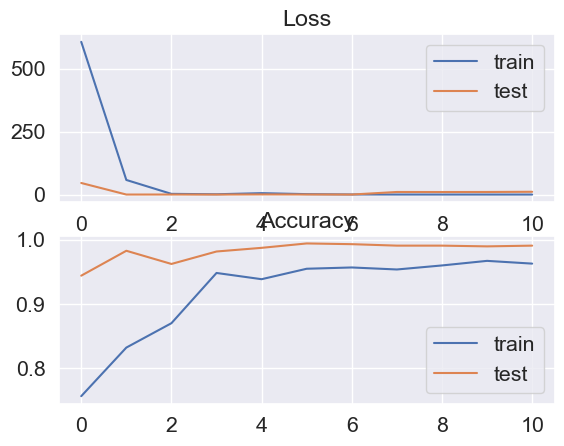

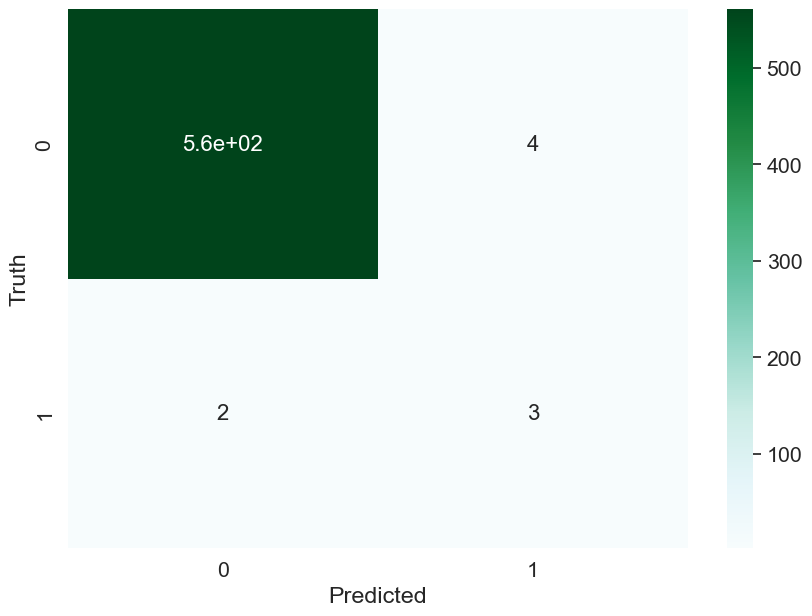

		 Prediction Metrics

Accuracy:	 0.989
Precision:	 0.429
Recall:		 0.600

F1 Score:	 0.500
ROC AUC:	 0.784
Balanced
Accuracy:	 0.796

Sensitivity:	 0.600
Specificity:	 0.993
Geometric Mean:	 0.772


In [ ]:
cnn_model()

The score isn't perfect, but it's possible to achieve perfect score after multiple simulations. You can download pre-trained weights and code from my [Github repository](https://github.com/ztsv-av/exoplanet) and check out results yourself.

Here's the result from the model that used pre-trained weights that I mentioned above:

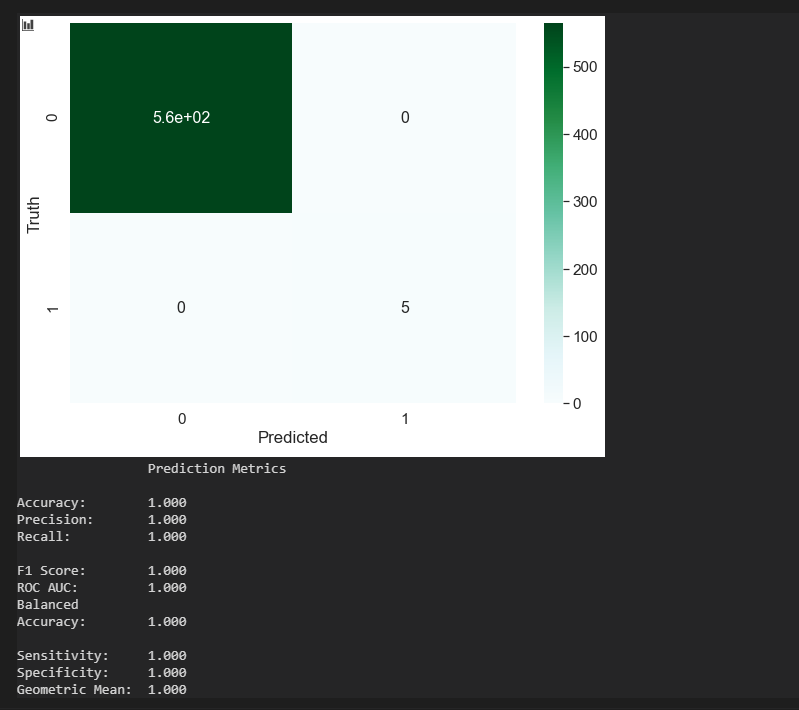

If you have any comments or questions, let me know.

Searching over 10 sampled hyperparameter combinations (out of 729 total)...
[1/10] filters=12, d1=64, d2=16, dC=0.15, dD=0.5, lr=1e-02 -> val_acc=0.8139
[1/10] filters=12, d1=64, d2=16, dC=0.15, dD=0.5, lr=1e-02 -> val_acc=0.8139
[2/10] filters=8, d1=48, d2=18, dC=0.15, dD=0.5, lr=1e-02 -> val_acc=1.0000
[2/10] filters=8, d1=48, d2=18, dC=0.15, dD=0.5, lr=1e-02 -> val_acc=1.0000
[3/10] filters=8, d1=32, d2=16, dC=0.25, dD=0.5, lr=5e-03 -> val_acc=0.8390
[3/10] filters=8, d1=32, d2=16, dC=0.25, dD=0.5, lr=5e-03 -> val_acc=0.8390
[4/10] filters=10, d1=32, d2=18, dC=0.2, dD=0.3, lr=1e-03 -> val_acc=0.9897
[4/10] filters=10, d1=32, d2=18, dC=0.2, dD=0.3, lr=1e-03 -> val_acc=0.9897
[5/10] filters=10, d1=32, d2=16, dC=0.15, dD=0.5, lr=5e-03 -> val_acc=0.9932
[5/10] filters=10, d1=32, d2=16, dC=0.15, dD=0.5, lr=5e-03 -> val_acc=0.9932
[6/10] filters=8, d1=64, d2=24, dC=0.2, dD=0.4, lr=1e-02 -> val_acc=0.9760
[6/10] filters=8, d1=64, d2=24, dC=0.2, dD=0.4, lr=1e-02 -> val_acc=0.9760
[7/10] fil

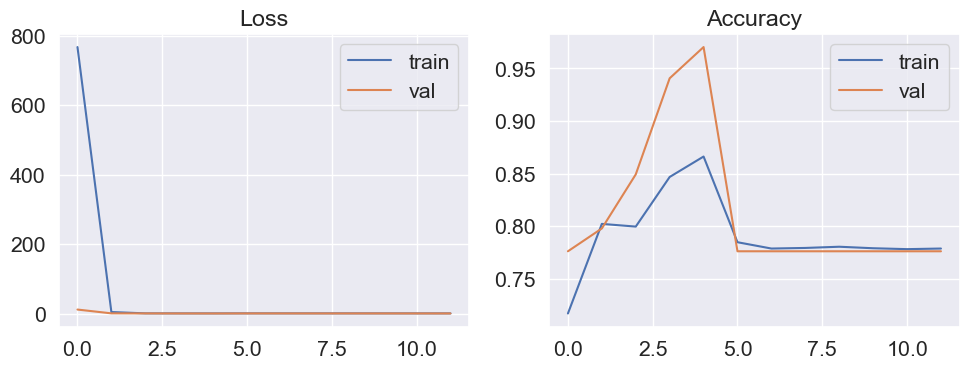

Saved hyperparameter search results to hyperparameter_search_results.json


In [ ]:
# Hyperparameter Optimization (lightweight random search)
# This cell performs a small random search over selected hyperparameters,
# retrains the best configuration on the full training data, and stores it in `final_model`.

import random, math, json, datetime, os
from itertools import product
from tensorflow.keras import backend as K

# Reuse existing dataset preparation
x_train, y_train, x_test, y_test, n_features = datasets()
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# Define search space
param_grid = {
    'filters': [8, 10, 12],
    'dense1': [32, 48, 64],
    'dense2': [16, 18, 24],
    'dropout_conv': [0.15, 0.2, 0.25],
    'dropout_dense': [0.3, 0.4, 0.5],
    'lr': [1e-2, 5e-3, 1e-3]
}

all_combos = list(product(param_grid['filters'], param_grid['dense1'], param_grid['dense2'],
                          param_grid['dropout_conv'], param_grid['dropout_dense'], param_grid['lr']))

# Limit the number of sampled combinations to keep runtime reasonable
MAX_SAMPLE = 10
random.seed(42)
sampled_combos = random.sample(all_combos, min(MAX_SAMPLE, len(all_combos)))

results = []

def build_model(filters, dense1, dense2, dropout_conv, dropout_dense, lr):
    model = Sequential([
        Input(shape=(3197,), name='flux_input'),
        Reshape((3197, 1)),
        Conv1D(filters=filters, kernel_size=2, activation='relu', kernel_regularizer='l2'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(dropout_conv),
        Flatten(),
        Dense(dense1, activation='relu'),
        Dropout(dropout_dense),
        Dense(dense2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print(f"Searching over {len(sampled_combos)} sampled hyperparameter combinations (out of {len(all_combos)} total)...")
for i, (filters, dense1, dense2, dconv, ddense, lr) in enumerate(sampled_combos, start=1):
    model = build_model(filters, dense1, dense2, dconv, ddense, lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=15,  # shorter epochs for search
        batch_size=64,
        verbose=0,
        callbacks=[early_stop]
    )
    best_val_acc = max(history.history['val_accuracy'])
    results.append({
        'filters': filters,
        'dense1': dense1,
        'dense2': dense2,
        'dropout_conv': dconv,
        'dropout_dense': ddense,
        'lr': lr,
        'val_accuracy': float(best_val_acc),
        'epochs_trained': len(history.history['loss'])
    })
    print(f"[{i}/{len(sampled_combos)}] filters={filters}, d1={dense1}, d2={dense2}, dC={dconv}, dD={ddense}, lr={lr:.0e} -> val_acc={best_val_acc:.4f}")
    K.clear_session()

# Select best configuration
results_sorted = sorted(results, key=lambda r: r['val_accuracy'], reverse=True)
best_cfg = results_sorted[0]
print("\nBest hyperparameters found:")
for k, v in best_cfg.items():
    if k != 'val_accuracy':
        print(f"  {k}: {v}")
print(f"  val_accuracy: {best_cfg['val_accuracy']:.4f}")

# Retrain best model thoroughly
print("\nRetraining best configuration with full schedule (up to 30 epochs + early stopping)...")
final_model = build_model(best_cfg['filters'], best_cfg['dense1'], best_cfg['dense2'],
                          best_cfg['dropout_conv'], best_cfg['dropout_dense'], best_cfg['lr'])
final_early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
final_history = final_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=2,
    callbacks=[final_early_stop]
 )

train_loss, train_acc = final_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Final Model Accuracy -> Train: {train_acc:.4f} | Test: {test_acc:.4f}")

# Optional: visualize training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(final_history.history['loss'], label='train')
plt.plot(final_history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(final_history.history['accuracy'], label='train')
plt.plot(final_history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Store search results to JSON for reproducibility
with open('hyperparameter_search_results.json', 'w') as f:
    json.dump({'results': results_sorted, 'best': best_cfg}, f, indent=2)
print("Saved hyperparameter search results to hyperparameter_search_results.json")

In [ ]:
# Export the tuned model and provide usage instructions (enhanced with full metrics)
import textwrap, json, pathlib, datetime
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             balanced_accuracy_score, confusion_matrix)

EXPORT_DIR = pathlib.Path('exported_model')
EXPORT_DIR.mkdir(exist_ok=True)
MODEL_PATH = EXPORT_DIR / 'exo_cnn_tf.keras'            # native Keras format
WEIGHTS_PATH = EXPORT_DIR / 'exo_cnn_tf.weights.h5'     # weights naming per Keras 3
SAVEDMODEL_PATH = EXPORT_DIR / 'saved_model'            # SavedModel via export()
METADATA_PATH = EXPORT_DIR / 'model_metadata.json'
USAGE_PATH = EXPORT_DIR / 'USAGE.txt'

# Recompute detailed evaluation metrics on held-out test set
# (x_test, y_test, final_model, best_cfg, train_acc, test_acc already defined in previous cell)
y_prob = final_model.predict(x_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
FP = int(cm[0][1]); FN = int(cm[1][0]); TP = int(cm[1][1]); TN = int(cm[0][0])
sens = TP/(TP+FN) if (TP+FN) else 0.0
spec = TN/(TN+FP) if (TN+FP) else 0.0
geom_mean = (sens * spec) ** 0.5
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1v = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print('Export Metrics (threshold=0.5)')
print(f'Accuracy:        {acc:.3f}')
print(f'Precision:       {prec:.3f}')
print(f'Recall:          {rec:.3f}')
print(f'F1 Score:        {f1v:.3f}')
print(f'ROC AUC:         {auc:.3f}')
print(f'Balanced Acc:    {bal_acc:.3f}')
print(f'Sensitivity:     {sens:.3f}')
print(f'Specificity:     {spec:.3f}')
print(f'Geom. Mean:      {geom_mean:.3f}')
print(f'Confusion Matrix:\n{cm}')

# Persist model artifacts
final_model.save(MODEL_PATH)
final_model.save_weights(WEIGHTS_PATH)
try:
    final_model.export(SAVEDMODEL_PATH)
except AttributeError:  # fallback for older versions
    final_model.save(SAVEDMODEL_PATH)

# Metadata bundle
metadata = {
    'variant': 'smote_pipeline',
    'created_utc': datetime.datetime.utcnow().isoformat() + 'Z',
    'input_shape': list(final_model.input_shape),
    'best_hyperparameters': best_cfg,
    'training_metrics': {
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc)
    },
    'evaluation_threshold': 0.5,
    'evaluation_metrics': {
        'confusion_matrix': cm.tolist(),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1v,
        'roc_auc': auc,
        'balanced_accuracy': bal_acc,
        'sensitivity': sens,
        'specificity': spec,
        'geometric_mean': geom_mean
    },
    'label_mapping': {'0': 'with_exoplanet', '1': 'without_exoplanet'},
    'preprocessing': {
        'outlier_handling': 'Per-row max & min replaced by mean (2 iterations)',
        'smote': 'SMOTE + RandomUnderSampler (over=0.2, under=0.3)',
        'scaling': 'Not applied (raw flux)',
        'shuffle': 'Applied before training'
    },
    'notes': 'Model selected via lightweight random hyperparameter search then retrained with early stopping.'
}
with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=2)

# Usage instructions text
usage_instructions = textwrap.dedent(f"""
HOW TO USE THE SMOTE-ENHANCED EXOPLANET CNN
==========================================
Artifacts:
  - Native Keras model: {MODEL_PATH}
  - Weights only:       {WEIGHTS_PATH}
  - SavedModel dir:     {SAVEDMODEL_PATH}
  - Metadata JSON:      {METADATA_PATH}

1. Install dependencies
   pip install tensorflow pandas numpy scikit-learn imbalanced-learn

2. Load the model (preferred)
   from tensorflow.keras.models import load_model
   model = load_model(r"{MODEL_PATH}")

   # SavedModel alternative
   # model = load_model(r"{SAVEDMODEL_PATH}")

   # Rebuild + load weights example (if you want to alter compile settings):
   # from tensorflow.keras.models import Sequential
   # from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
   # def rebuild():
   #     m = Sequential([
   #         Input(shape=(3197,)), Reshape((3197,1)),
   #         Conv1D(filters={best_cfg['filters']}, kernel_size=2, activation='relu', kernel_regularizer='l2'),
   #         MaxPooling1D(pool_size=2, strides=2), Dropout({best_cfg['dropout_conv']}), Flatten(),
   #         Dense({best_cfg['dense1']}, activation='relu'), Dropout({best_cfg['dropout_dense']}),
   #         Dense({best_cfg['dense2']}, activation='relu'), Dense(1, activation='sigmoid')])
   #     return m
   # model = rebuild(); model.load_weights(r"{WEIGHTS_PATH}")

3. Prepare new data for inference
   - Shape: (n_samples, 3197)
   - Apply outlier handling (replace per-row max & min with mean, 2 iterations)
   - DO NOT apply SMOTE at inference (only for training)
   - Maintain original flux column ordering

4. Predict
   probs = model.predict(X).ravel()
   preds = (probs >= 0.5).astype(int)   # consider threshold tuning if recall for class 1 is critical

5. Label mapping
   0 -> with_exoplanet
   1 -> without_exoplanet

6. Inspect metadata
   See model_metadata.json for hyperparameters + full diagnostic metrics.

7. Improving minority detection
   - Threshold tuning (Youden J or PR curve)
   - Alternate losses (focal loss)
   - Additional Conv blocks / filter expansion
   - Ensemble averaging of several tuned runs

8. Reproducibility
   GPU nondeterminism causes slight metric drift. Fix seeds and set deterministic ops for stricter reproducibility.
""").strip()

with open(USAGE_PATH, 'w', encoding='utf-8') as f:
    f.write(usage_instructions)

print('\nArtifacts saved:')
print(f'  Keras model:   {MODEL_PATH}')
print(f'  Weights:       {WEIGHTS_PATH}')
print(f'  SavedModel:    {SAVEDMODEL_PATH}')
print(f'  Metadata:      {METADATA_PATH}')
print(f'  Usage:         {USAGE_PATH}')
print('\nUsage preview (first lines):\n')
print('\n'.join(usage_instructions.splitlines()[:30]))

Export Metrics (threshold=0.5)
Accuracy:        0.977
Precision:       0.000
Recall:          0.000
F1 Score:        0.000
ROC AUC:         0.703
Balanced Acc:    0.493
Sensitivity:     0.000
Specificity:     0.986
Geom. Mean:      0.000
Confusion Matrix:
[[557   8]
 [  5   0]]
INFO:tensorflow:Assets written to: exported_model\saved_model\assets
INFO:tensorflow:Assets written to: exported_model\saved_model\assets


INFO:tensorflow:Assets written to: exported_model\saved_model\assets


Saved artifact at 'exported_model\saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3197), dtype=tf.float32, name='flux_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1243325721744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048538640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048528848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048534800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048529040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048540752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048533072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1242048530000: TensorSpec(shape=(), dtype=tf.resource, name=None)

Artifacts saved:
  Keras model:   exported_model\exo_cnn_tf.keras
  Weights:       exported_model\exo_cnn_tf.weights.h5
  SavedModel:    exported_model\saved_model
  Meta

C:\Users\navid\AppData\Local\Temp\ipykernel_3608\1522709372.py:53: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'created_utc': datetime.datetime.utcnow().isoformat() + 'Z',
